In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import genpareto
matplotlib.use('TkAgg')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import trange, tqdm
#from anomaly_scoring import get_anomaly_scores

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchsummary import summary

import torchvision
from torchvision import datasets
from torchvision import transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline 

import utils
from utils import get_taxi_data_VAE, get_taxi_data_cVAE
from utils import softclip
from utils import plot_train_test_reconstructions_cvae, plot_train_test_reconstructions_prob_decoder_cvae_model
from models.cnn_sigmacVAE import CNN_sigmacVAE

import evaluation_utils

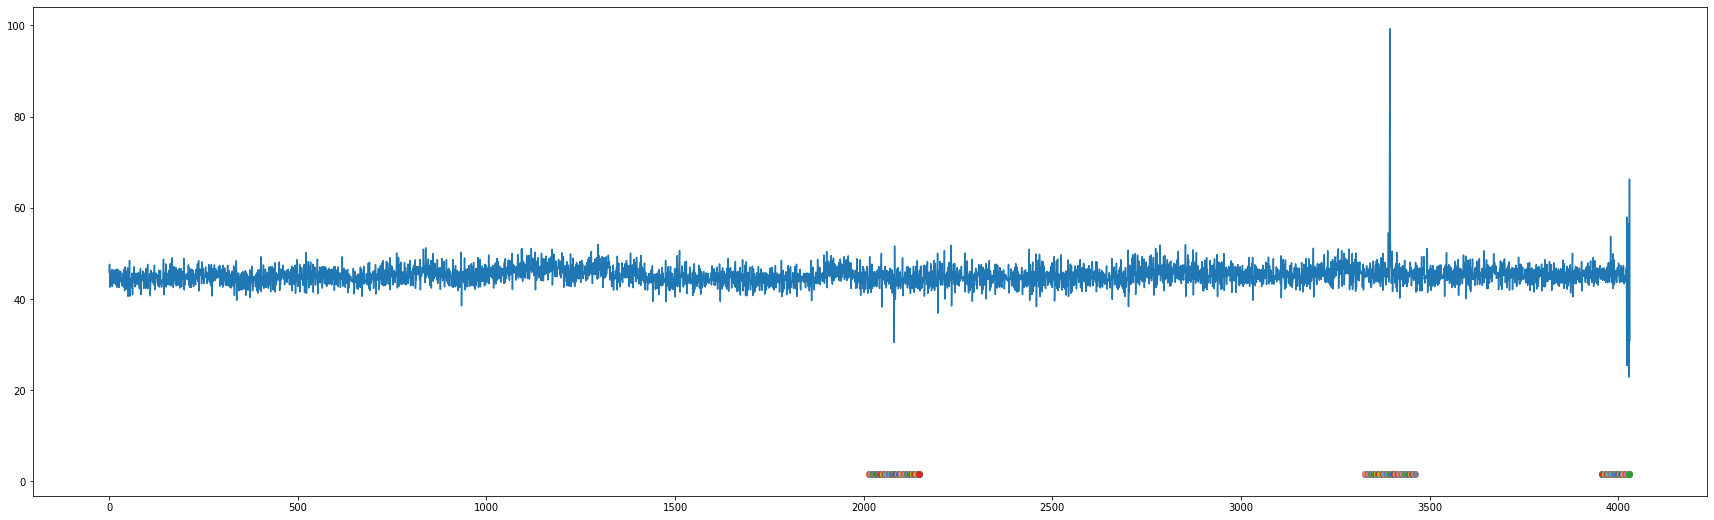

In [2]:
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/nyc_taxi.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/machine_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/cpu_utilization_asg_misconfiguration.csv'
dataset_path = '../../datasets/nab/NAB-master/data/realKnownCause/ec2_request_latency_system_failure.csv'

anomaly_timestamps, anomaly_windows = utils.get_anomaly_timestamps_and_windows(dataset_path)


    
#singular anomaly points
'''
window_size=20
cond_window_size=10
X_train_data, X_test_data, X_train_tensor, cond_train_tensor, X_test_tensor, cond_test_tensor, trainloader, testloader = get_taxi_data_cVAE(dataset_path,window_size=window_size,cond_window_size=cond_window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])
    
anomaly_idxs = []
for timestamp in anomaly_timestamps:
    start = timestamp

    loc_start = timestamps.index(start)
    anomaly_idxs.append(loc_start)
    
anomaly_idxs = np.array(anomaly_idxs)    
'''



#anomaly windows code

window_size=20
cond_window_size=10
X_train_data, X_test_data, X_train_tensor, cond_train_tensor, X_test_tensor, cond_test_tensor, trainloader, testloader = get_taxi_data_cVAE(dataset_path,window_size=window_size,cond_window_size=cond_window_size,train_test_split=.5) 

data = pd.read_csv(dataset_path)

timestamps = list(pd.read_csv(dataset_path)['timestamp'])

anomaly_idxs = []
for timestamp in anomaly_windows:
    start, end = timestamp[0], timestamp[1]

    loc_start = timestamps.index(start)
    loc_end = timestamps.index(end)

    for i in range(loc_start, loc_end):
        anomaly_idxs.append(i)

anomaly_idxs = np.array(anomaly_idxs)
anomaly_idxs = anomaly_idxs[anomaly_idxs > 0]

plt.figure(figsize=(30,9))
for ai in anomaly_idxs:
    plt.scatter(ai, 1.7)


plt.plot(data['value'])
plt.show()


In [3]:
def train_model(model, num_epochs, learning_rate, dataloader):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    epochs=num_epochs
    tq = tqdm(range(epochs))
    for epoch in tq:
        flag = False
        for j, data in enumerate(dataloader, 0):

            model.train()
            
            optimizer.zero_grad()

            #batches
            inputs, cond = data
            inputs.to(device)
            cond.to(device)

            outputs, rec_mu, rec_sigma, kl = model(inputs, cond)

            rec_comps, rec, rec_mu_sigma_loss, kl = model.loss_function(outputs, inputs, rec_mu, rec_sigma, kl)

            loss = rec + kl + rec_mu_sigma_loss

            if(np.isnan(loss.item())):
                print("Noped out at", epoch, j, kl, rec_comps)
                flag = True
                break

            loss.backward()
            optimizer.step()
        if(flag):
            break
        tq.set_postfix(loss=loss.item())
        #print(epoch, 'total :' + str(loss.item()) + ' rec : ' + str(rec.item()) + ' kl : ' + str(kl.sum().item()) + ' sigma: ' + str(model.log_sigma.item()))

        #break
    return model

In [4]:
latent_dim=8
model = CNN_sigmacVAE(latent_dim=latent_dim, window_size=window_size, cond_window_size=cond_window_size, use_probabilistic_decoder=False)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 2000, .005, trainloader)

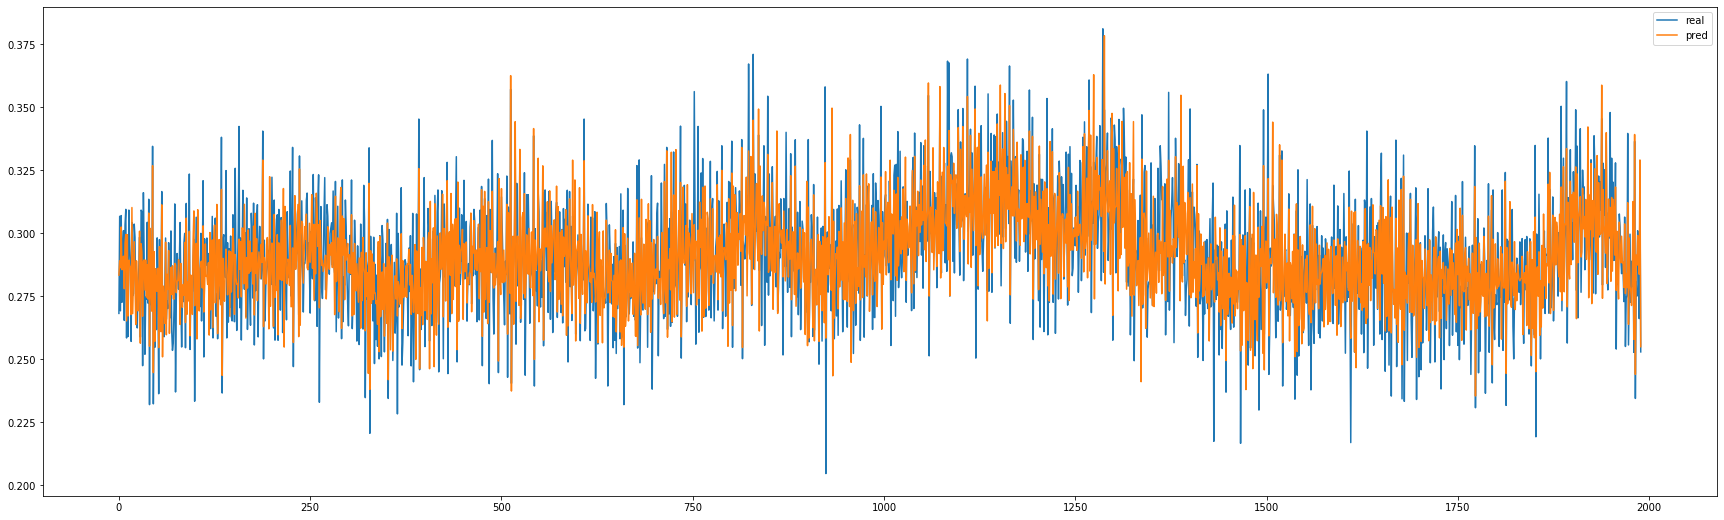

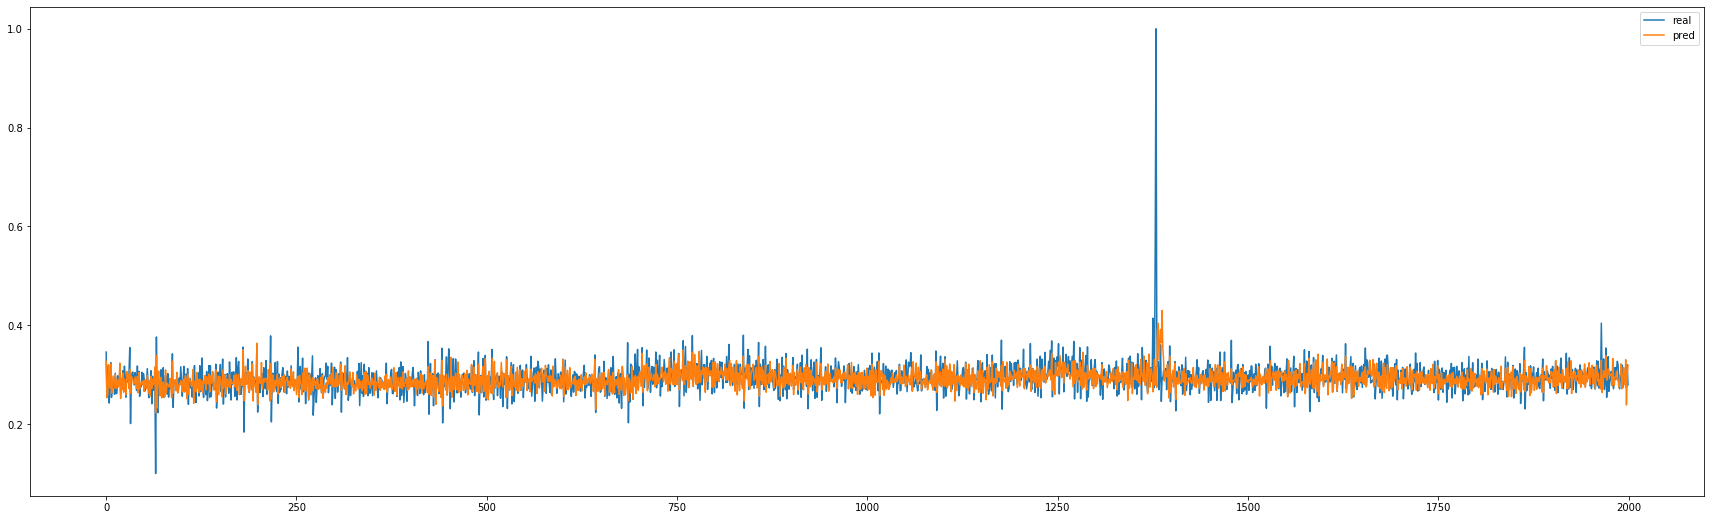

train MSE : 0.00024 test MSE : 0.00072


In [5]:
plot_train_test_reconstructions_cvae(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size) 


Computing AUPR for 2000 thresholds ... 


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


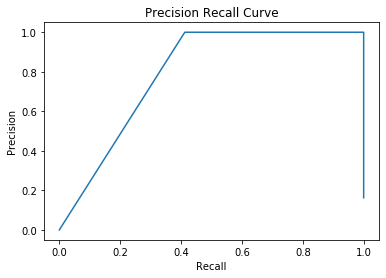


--- AUPR ---
0.7938461538461539
Best F1 score : 1.0 at threshold : -0.004730638501922405 (1-percentile : 0.0)
Corresponding best precision : 1.0, best recall : 1.0


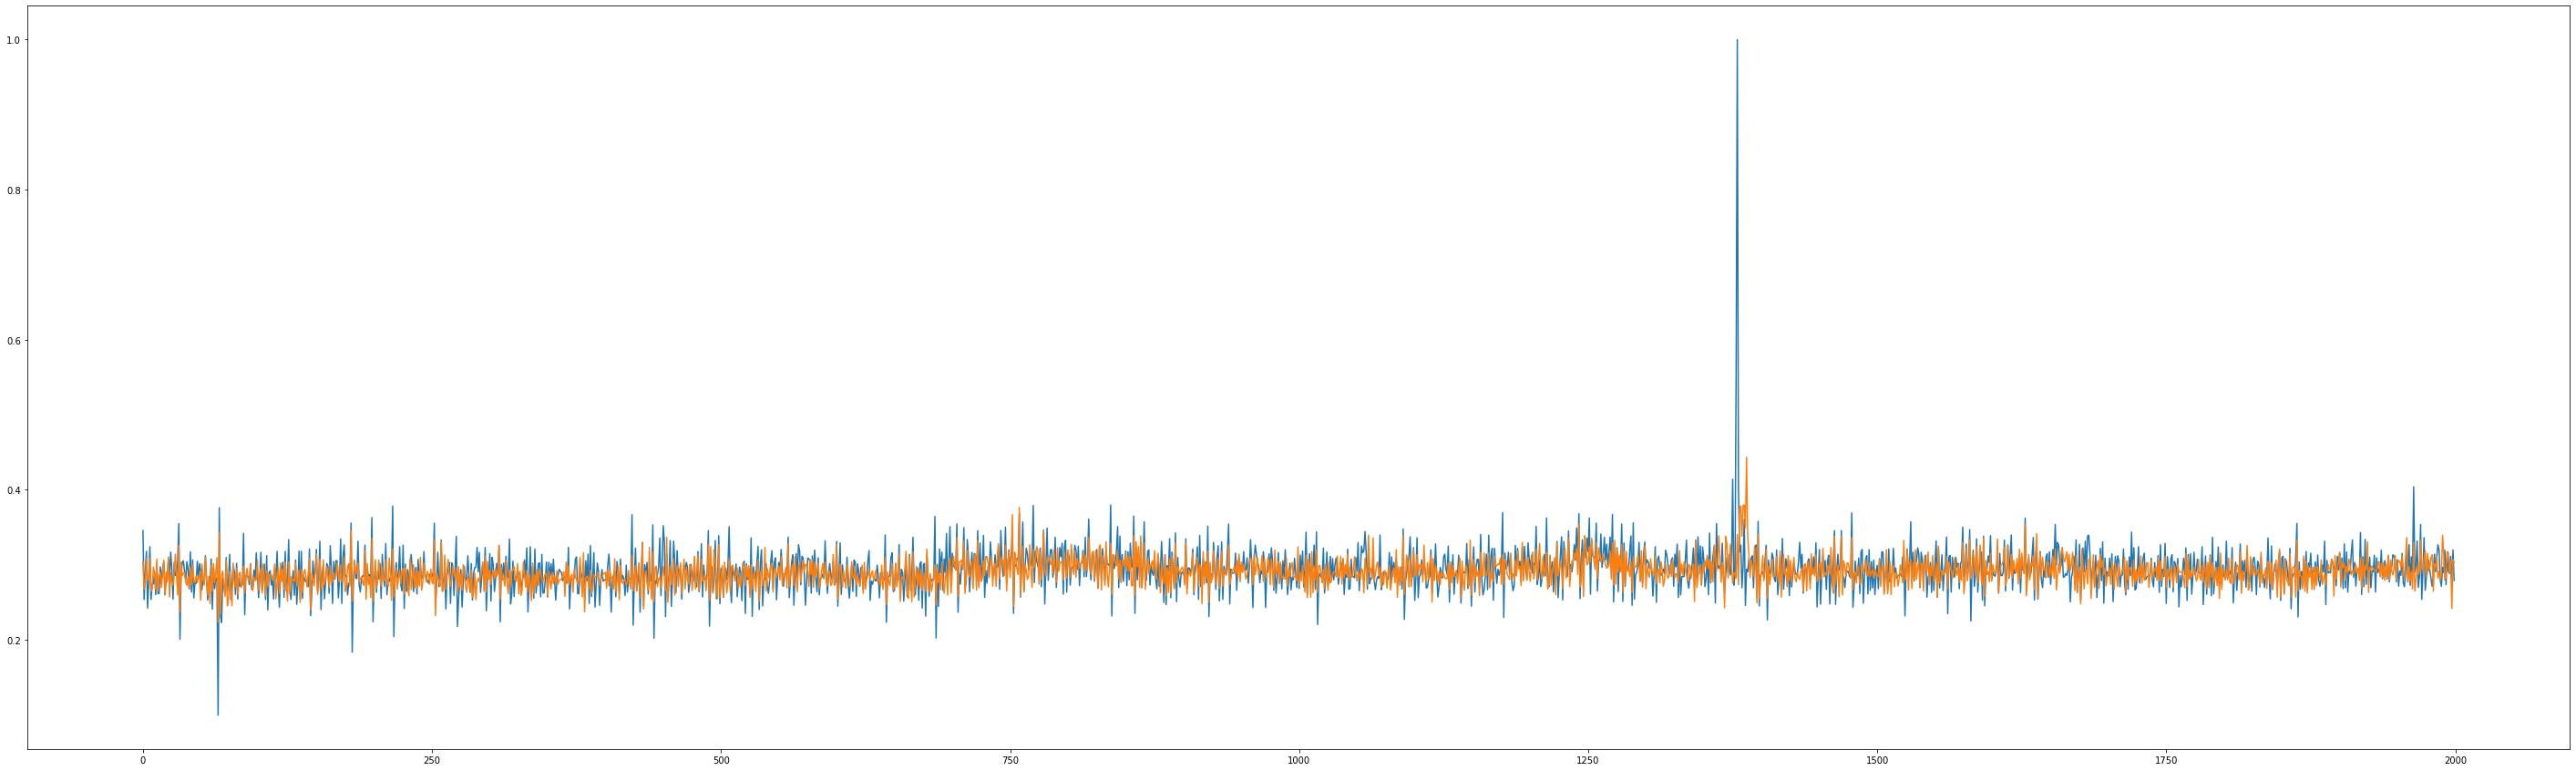

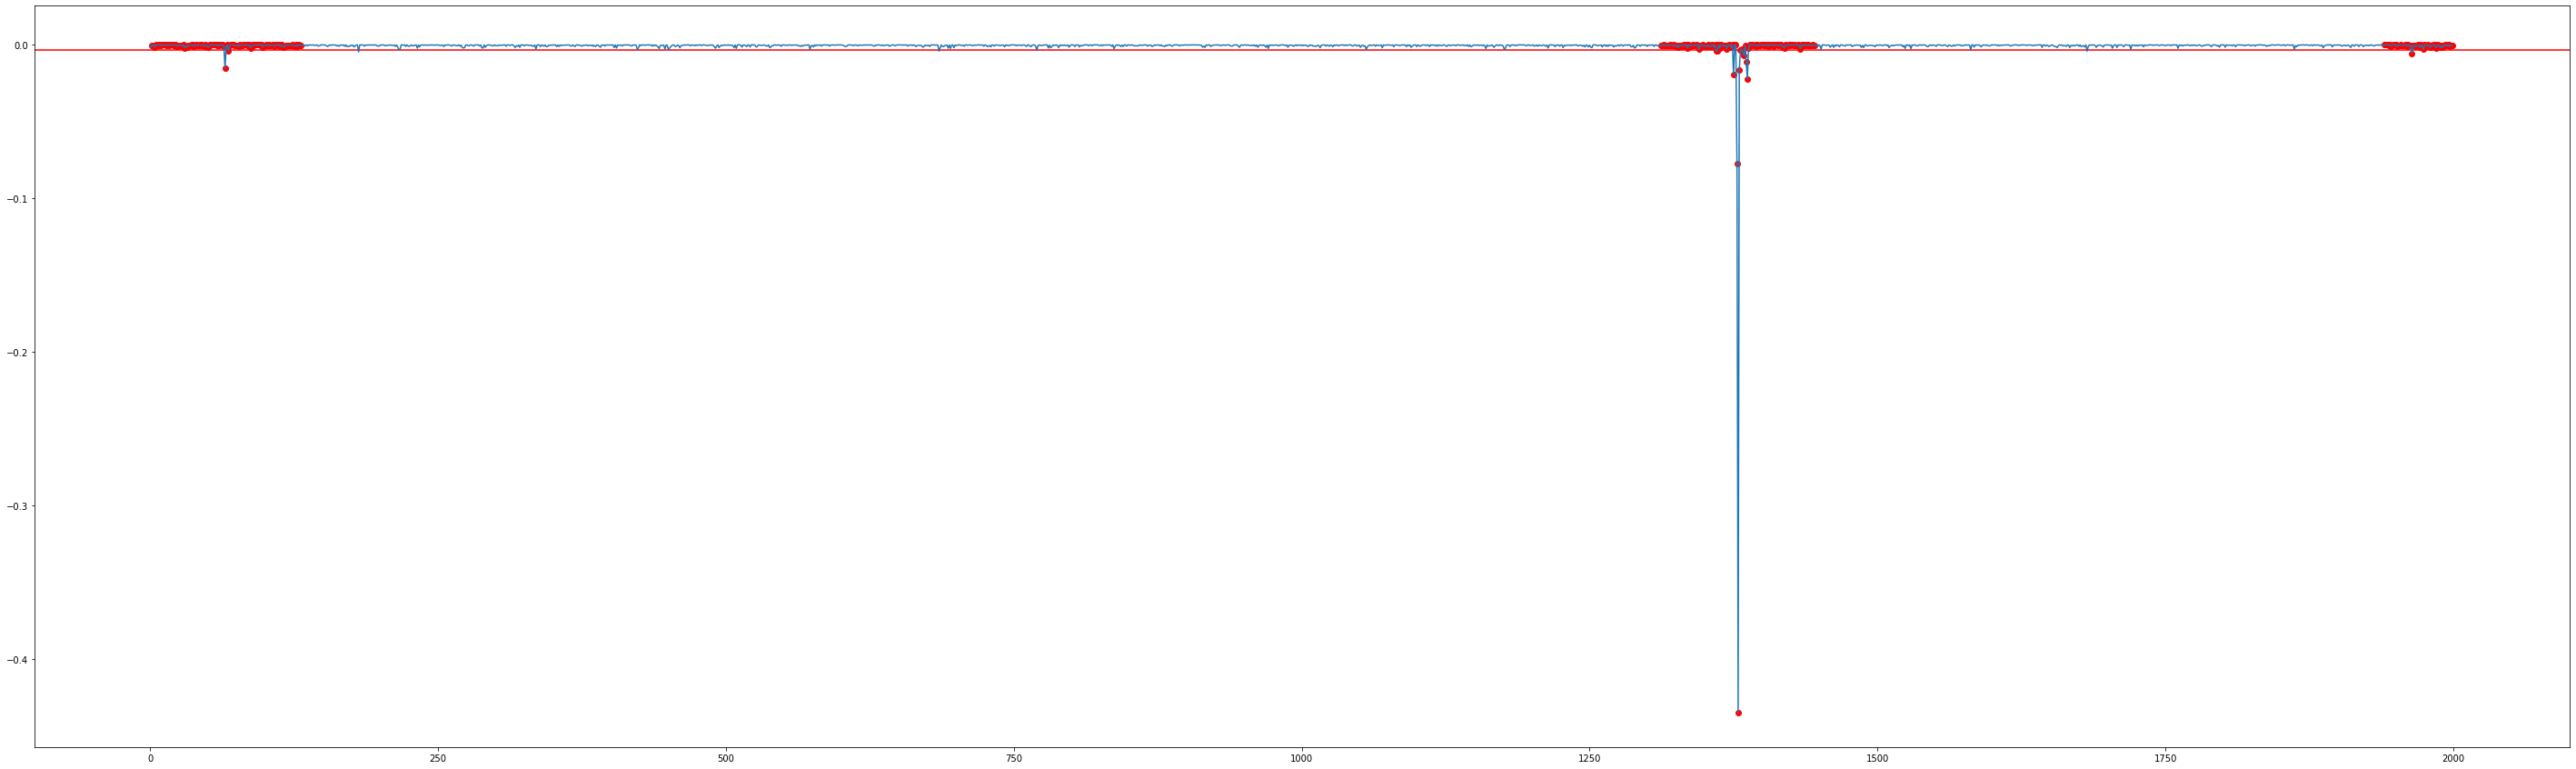


--- Metrics ---
precision : 0.9818731117824774 recall : 1.0 f1 : 0.9908536585365855




In [6]:
evaluation_utils.cVAE_anomaly_detection(model, X_test_tensor, X_test_data, cond_test_tensor, X_train_data, anomaly_idxs, .01)

# Probabilistic Decoder

In [7]:
latent_dim=8
model = CNN_sigmacVAE(latent_dim=latent_dim, window_size=window_size, cond_window_size=cond_window_size, use_probabilistic_decoder=True)
model.to(device)
model.cuda() if torch.cuda.is_available() else model.cpu()

model = train_model(model, 2000, .005, trainloader)

torch.Size([200, 1, 20])
torch.Size([199, 1, 20])


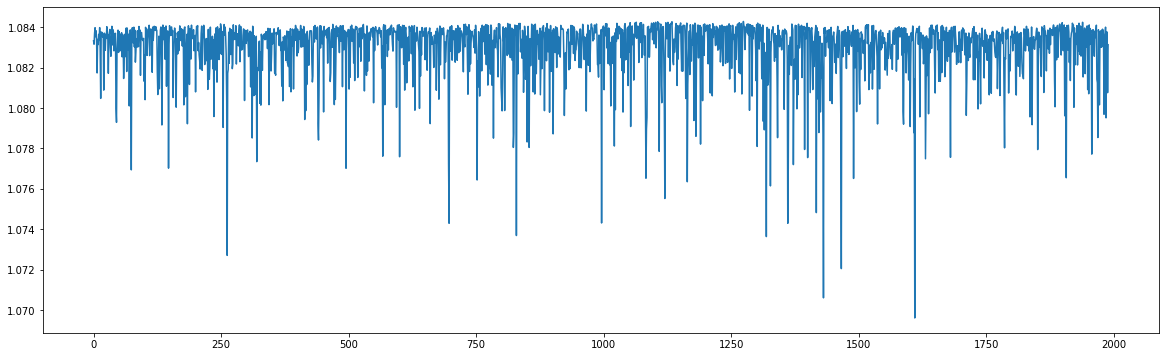

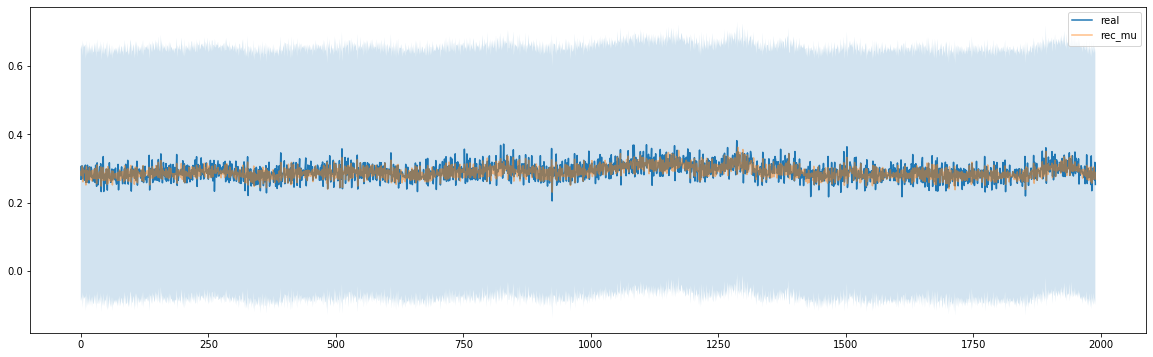

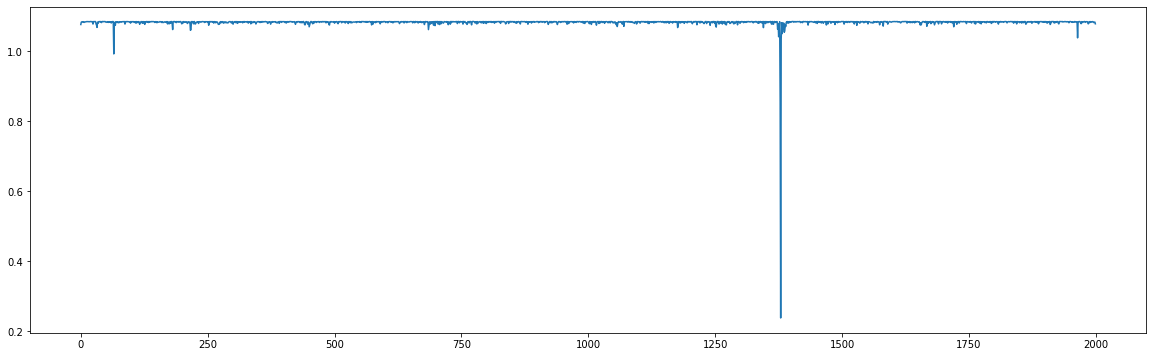

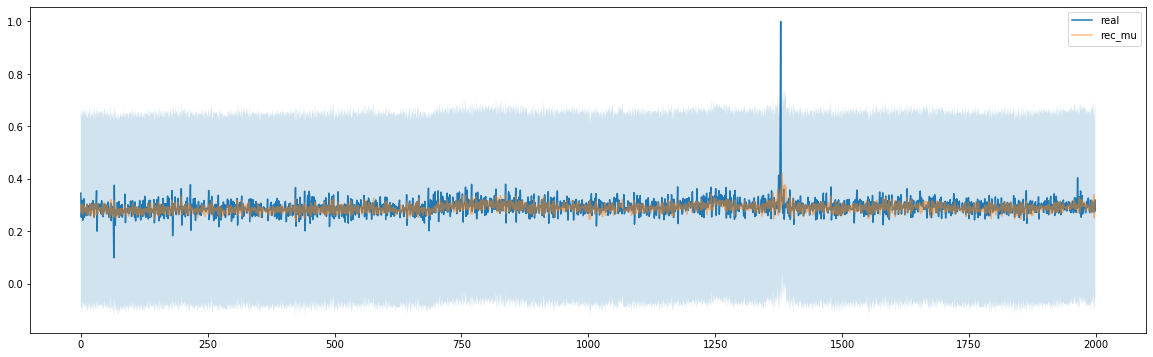

train MSE : 0.00021 test MSE : 0.00069


In [8]:
print(X_test_tensor.shape)
print(X_train_tensor.shape)

plot_train_test_reconstructions_prob_decoder_cvae_model(model, X_train_tensor, X_train_data, X_test_tensor, X_test_data, cond_train_tensor, cond_test_tensor, window_size, cond_window_size)

# Evaluation

# redone


Computing AUPR for 2000 thresholds ... 


c:\python37\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


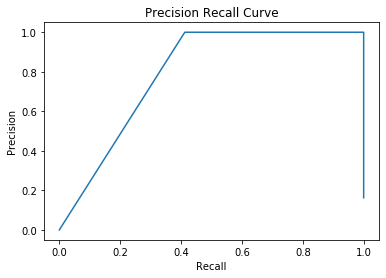


--- AUPR ---
0.7938461538461539
Best F1 score : 1.0 at threshold : 1.041661709707166 (1-percentile : 0.0)
Corresponding best precision : 1.0, best recall : 1.0
initial threshold : 1.0732131917022123


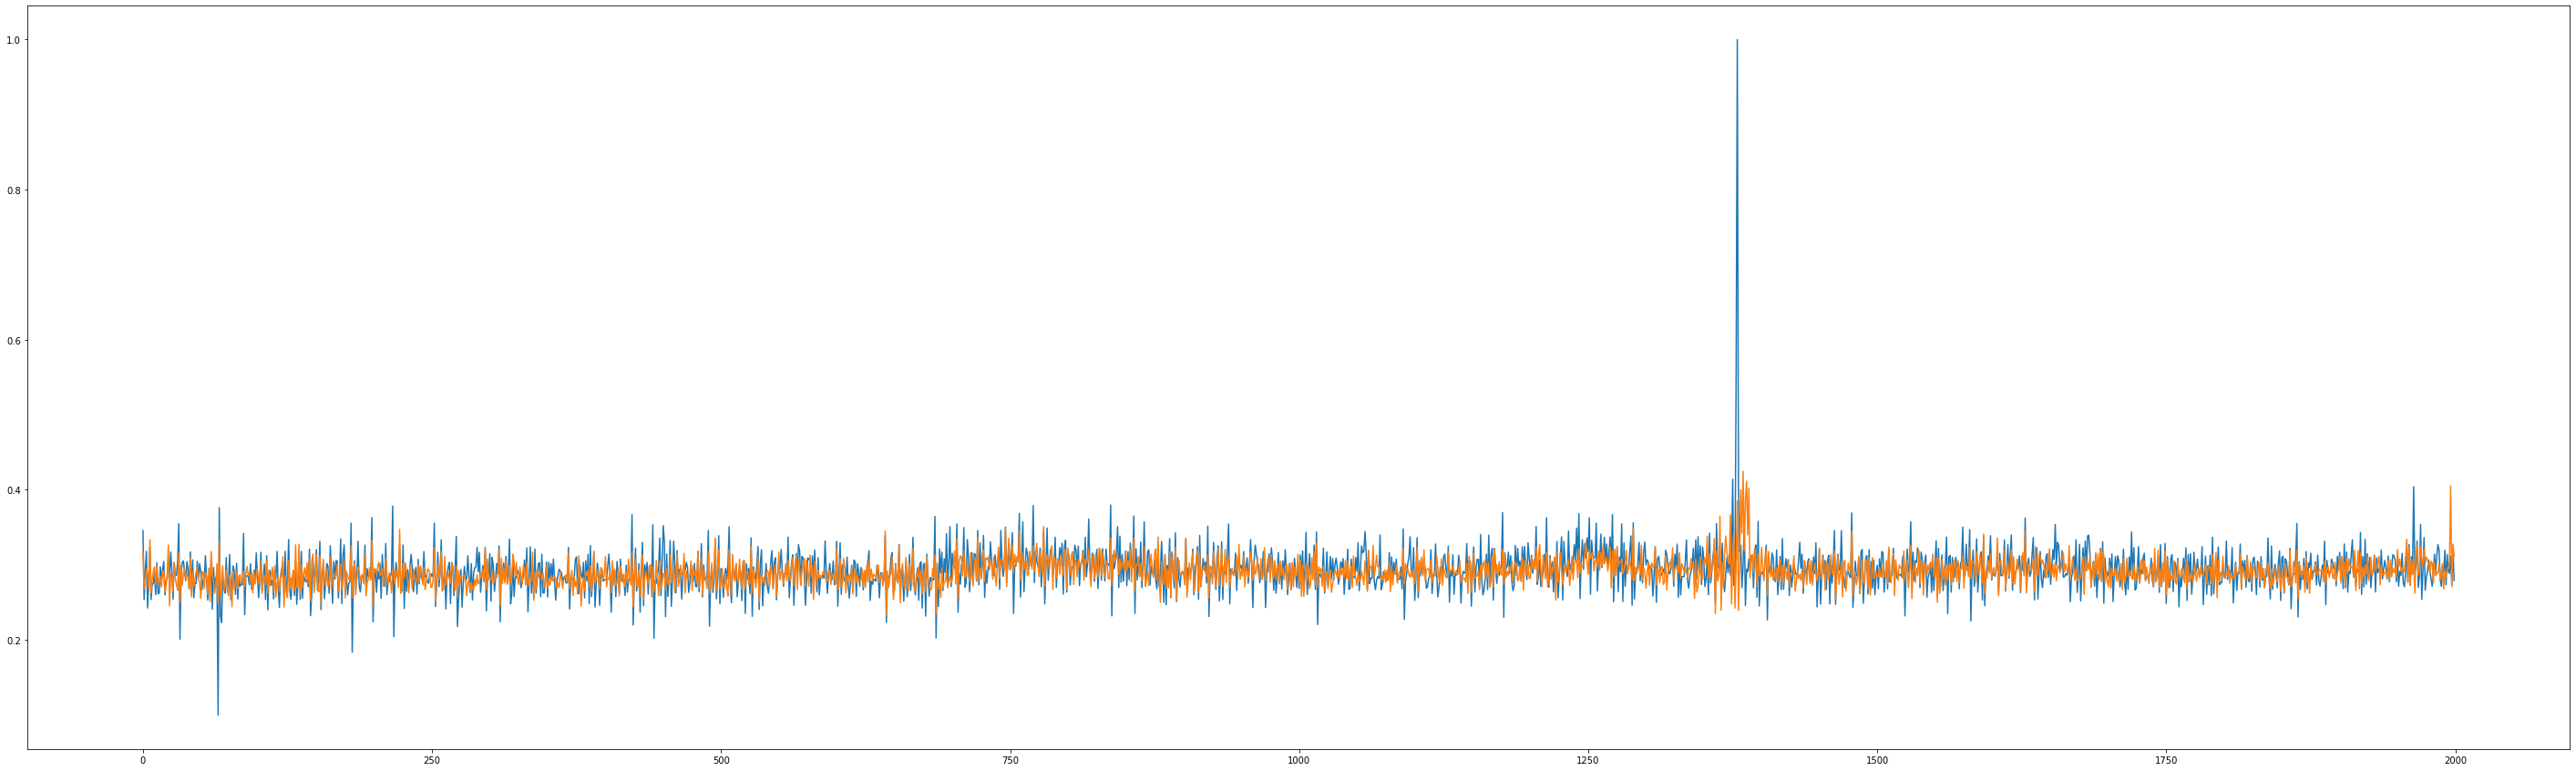

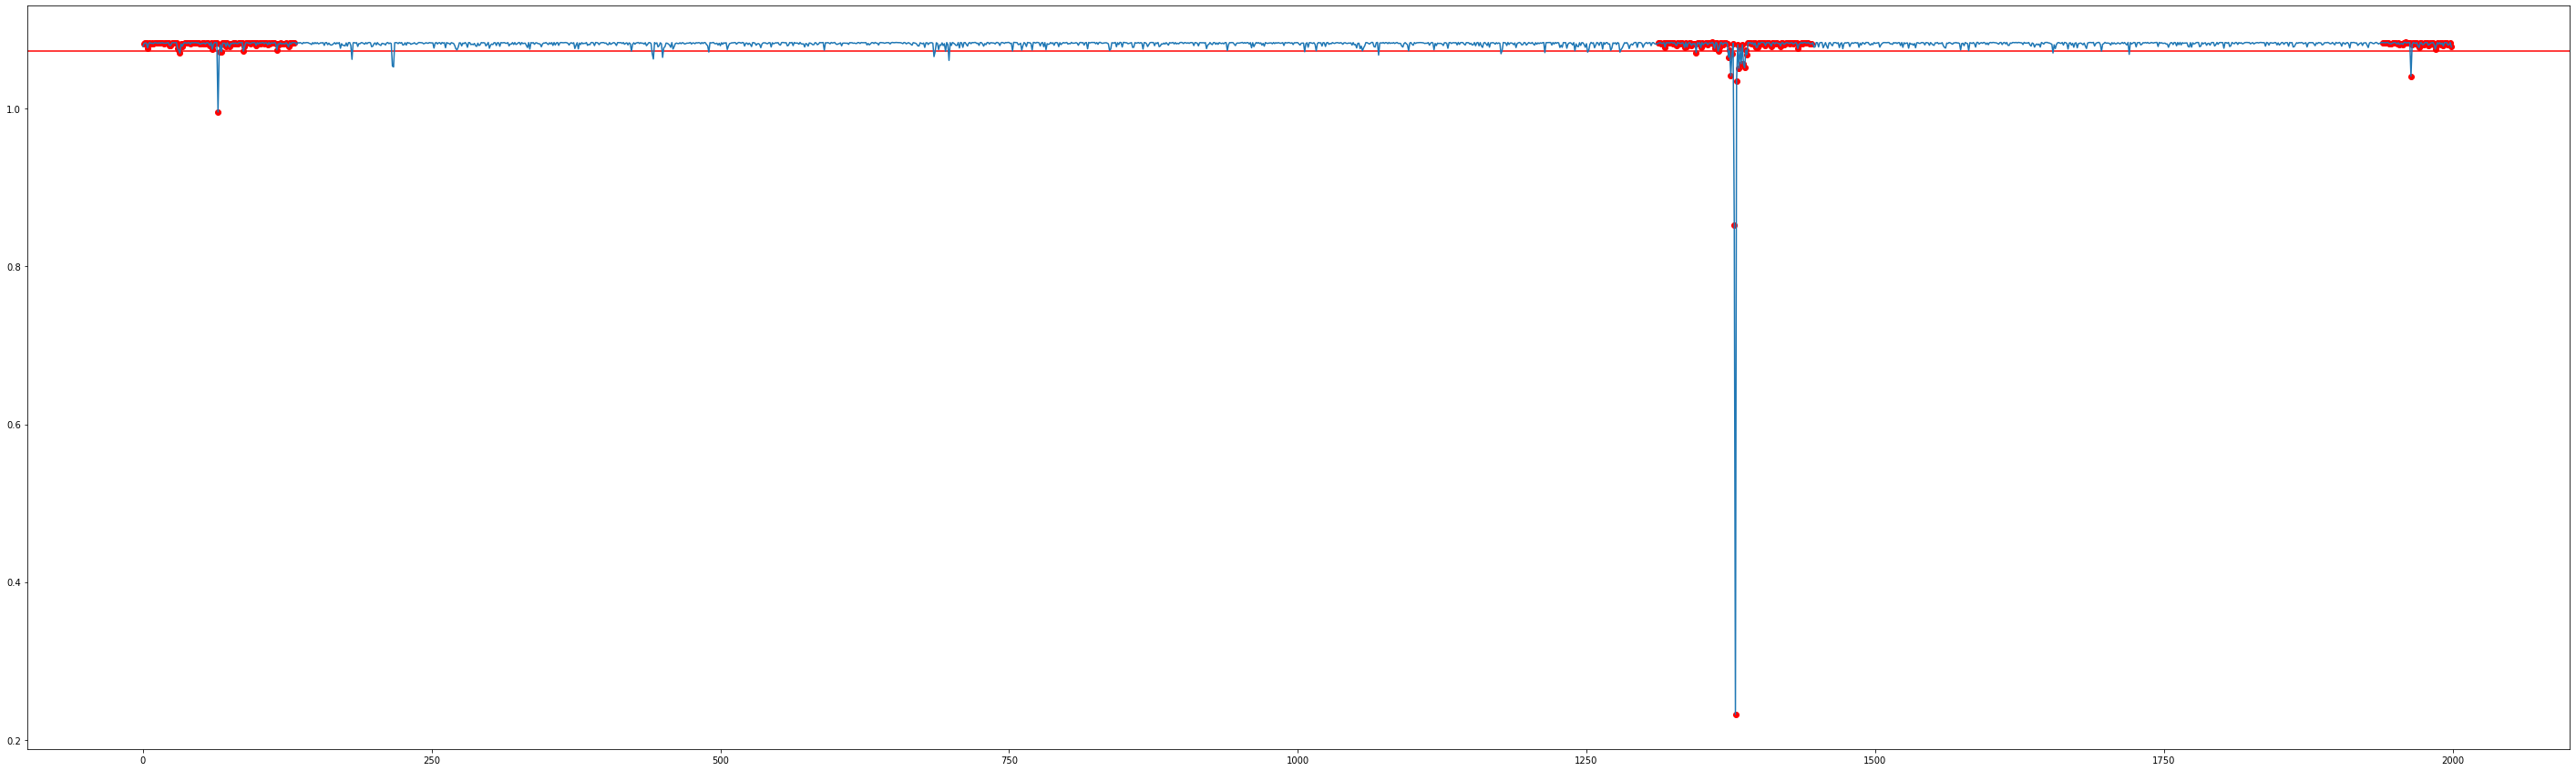


--- Metrics ---
precision : 0.9393063583815029 recall : 1.0 f1 : 0.9687034277198212


final threshold : 0.1830197008300829


c:\python37\lib\site-packages\scipy\stats\_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
c:\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
c:\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


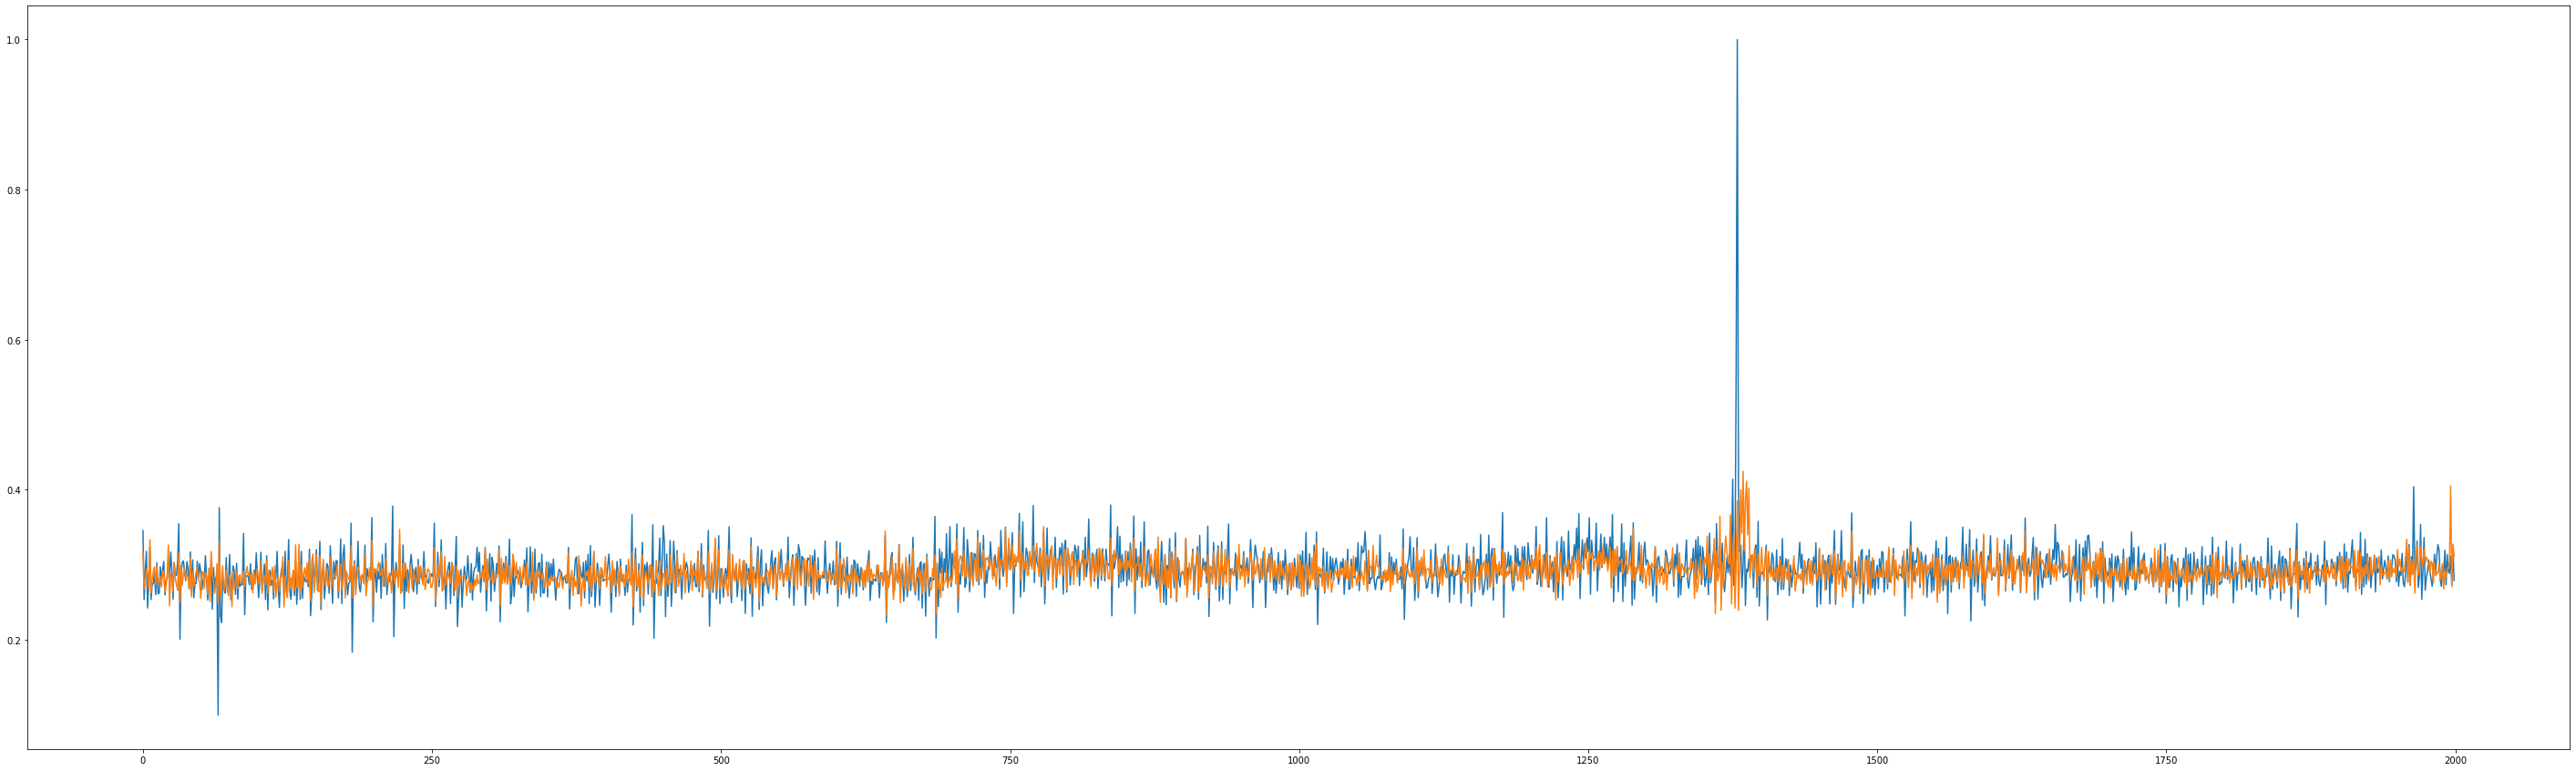

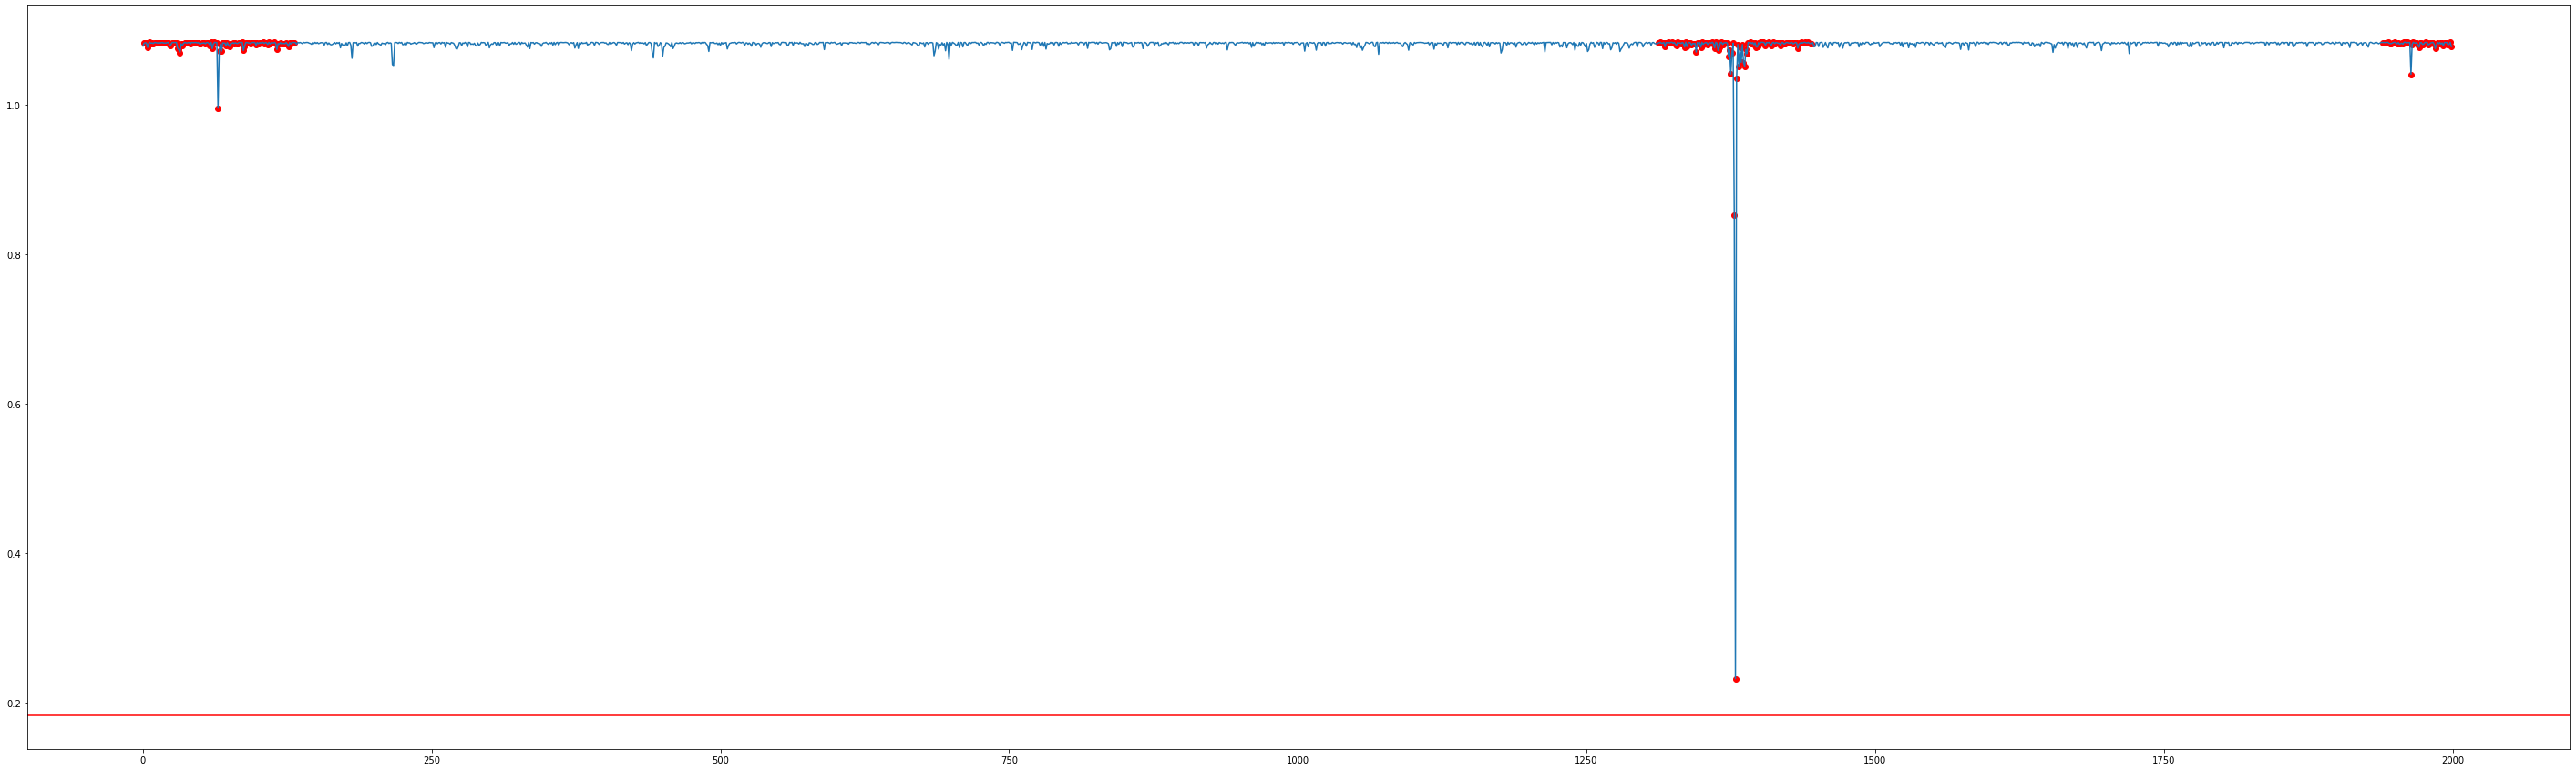


--- Metrics ---
precision : 0.0 recall : 0.0 f1 : 0.0




In [9]:


evaluation_utils.cVAE_prob_decoder_anomaly_detection(model, X_test_tensor, X_test_data, cond_test_tensor, X_train_data, anomaly_idxs, .02)